##  Evalue la qualité de la prédiction d'un modèle / d'une config en regards des métriques obtenues sur différents pas de temps

In [2]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern
from examples.train_model_on_k_fold_validation import load_configuration

In [79]:
import torch 
import pandas as pd 
from examples.train_and_visu_non_recurrent import get_ds

trial_id ='subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
args,_ = load_configuration(trial_id,load_config=True,epochs=None)


station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
training_mode_to_visualise = ['test']#,'valid','train']
modification ={'keep_best_weights':True,
                'epochs':1,
                'validation_split_method' : 'forward_chaining_cv',
                'min_fold_size_proportion': 0.75,
                'train_prop':0.6,
                'valid_prop':0.2,
                'test_prop':0.2,

                'set_spatial_units':['BEL','PER','PAR','GER','CHA'],
        
                'data_augmentation': False #True,  #False
                #'DA_method':'interpolation',
                #'DA_moment_to_focus' :[{'hours':[0,23],'weekdays':[1,3]}], # None
                }
ds,args_modif,trial_id,save_folder,df_loss = get_ds(args.model_name,args.dataset_names,args.dataset_for_coverage,
                                              modification=modification,args_init=args,fold_to_evaluate=[args.K_fold-1])

U_train_copy = ds.U_train.clone()
Utarget_train_copy = ds.Utarget_train.clone()
dates_train = ds.tensor_limits_keeper.df_verif_train.iloc[:,-1].reset_index(drop=True)
p_inject = 1
alpha = 1

# Seasonal decomposition : 
# Init 
min_count = 10

weekly_period =  (24-len(USELESS_DATES['hour']))*(7-len(USELESS_DATES['weekday']))*4
daily_period =  (24-len(USELESS_DATES['hour']))*4
period = [weekly_period,daily_period]

decomposition = get_noise_from_time_series(ds,min_count = min_count, period = period)

df_noises = pd.DataFrame({col : decomposition[col]['resid'] for col in decomposition.keys()})
df_noises = df_noises[ds.spatial_unit]
# plot decomposition :
if False: 
    for key in decomposition.keys():
        recompose_ts_and_plot(decomposition[key],key,start = 96*7, nb_timeslots= 96*2)


>>>> Load best CONFIG
Considered Spatial-Unit:  ['BEL', 'PER', 'PAR', 'GER', 'CHA']

Init Dataset:  torch.Size([7392, 5])
Number of Nan Value:  tensor(0)
Total Number of Elements:  36960 

Init U/Utarget size: torch.Size([4702, 5, 7])/torch.Size([4702, 5, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing


In [113]:
from DL_class import FeatureVectorBuilder #,DatesVerifFeatureVect,TensorLimitsKeeper
import numpy as np 

featurevectorbuilder = FeatureVectorBuilder(ds.step_ahead,ds.H,ds.D,ds.W,ds.Day_nb_steps,ds.Week_nb_steps,ds.shift_from_first_elmt)
U_train_copy = ds.U_train.clone()
Utarget_train_copy = ds.Utarget_train.clone()
dates_train = ds.tensor_limits_keeper.df_verif_train.iloc[:,-1].reset_index(drop=True)
start,end = ds.tensor_limits_keeper.df_verif_train.min().min(),ds.tensor_limits_keeper.df_verif_train.max().max()
n, N, L = U_train_copy.shape

# Parameter of Noise Injection :
p_inject = 1
alpha = 1

# mask_inject : bool de taille [n, N].  On choisit aléatoirement p_inject% des sequences (t, i) à bruiter
mask_inject = torch.rand(n, N) < p_inject
mask_seq_3d = mask_inject.unsqueeze(-1).expand(-1, -1, L)  # Repeat on the dimension L

# Transform df to tensor: 
df_noises_with_init_dates = df_noises.reindex(pd.date_range(start, end, freq=f'{60//ds.time_step_per_hour}min'))
tensor_noises = torch.from_numpy(df_noises_with_init_dates.values).float()

# Built Feature vector to get adapted noise for evey elemt of the sequence:
featurevectorbuilder.build_feature_vect(tensor_noises)
featurevectorbuilder.build_target_vect(tensor_noises)
mask_U =  [e for e in np.arange(featurevectorbuilder.U.shape[0]) if e not in ds.forbidden_indice_U]
amp_values = featurevectorbuilder.U[mask_U]
amp_values_target = featurevectorbuilder.Utarget[mask_U]

# Gaussian Noise
noise = torch.randn(n, N, L)  # Gaussian Noise

# Scaled with computed amplitude and an 'alpha' factor: 
raw_noise = noise * alpha * amp_values  # shape [n, N, L]
scaled_noise = ds.normalizer.normalize_tensor(raw_noise,feature_vect=True)
# Noise injection on some masked values 
U_train_copy += scaled_noise * mask_seq_3d

Values with issues:  4.254%
Regular Values that we have to set to 0:  0.000%


In [120]:

class Normalizer(object):
    def __init__(self,reference = None,minmaxnorm = False, standardize = False, dims = None):
        self.minmaxnorm = minmaxnorm
        self.standardize = standardize
        self.dims = dims
        reshaped_inputs = self.reshape_input(reference,dims)
        self.get_stats(reshaped_inputs)  # Get Min, Max, Mean, Std 

    def reshape_input(self,inputs,dims):
        # Design Permutation tuple: 
        int_dims = [dim if dim>=0 else inputs.dim()+dim for dim in dims ]   
        int_dims = sorted(int_dims)
        remaining_dims = [dim for dim in np.arange(inputs.dim()) if not(dim in int_dims)] 
        permutations = remaining_dims+int_dims
        self.permutations = permutations
        
        #Permute 
        permuted_inputs = inputs.permute(tuple(permutations))
        self.permuted_size = permuted_inputs.size()
        
        # Reshape (flattening 'input' through dimension 'dims')
        reshape = tuple([permuted_inputs.size(k) for k,_ in enumerate(remaining_dims)]+[-1]) 
        reshaped_inputs = permuted_inputs.reshape(reshape)

        self.reshaped_inputs_dim =  reshaped_inputs.size()
        return(reshaped_inputs)

    def get_stats(self,inputs: torch.Tensor): #,dims: tuple
        ''' Return Min, Max, Mean and Std of inputs through the choosen dimension 'dims' (which have been flattened)'''
        if (not(hasattr(self,'mini'))):
            self.mini = inputs.min(-1).values  
            #self.mini = inputs.min(dims).values  
        if (not(hasattr(self,'maxi'))): 
            self.maxi = inputs.max(-1).values
            #self.maxi = inputs.max(dims).values
        if (not(hasattr(self,'mean'))):
            self.mean= inputs.mean(-1)
            #self.mean = inputs.mean(dims)
        if (not(hasattr(self,'std'))): 
            self.std = inputs.std(-1)
            #self.std = inputs.std(dims)  

    def repeat_stats_tensor(self,X,S, feature_vect = False):
        '''
        According to argument 'dims', reshape and repeat tensor S to match dimension with X.

        args
        ----
        X : feature vector              >>>> torch.randn(T',N,C,H,W,L)
        I : Train input                 >>>> torch.randn(T,N,C,H,W)
        S : statistics (mini,mean...)   >>>> torch.randn(N,H)
        dims : dimension for which we have aggregated >>>> [0,2,4]  # cause we removed T,C,W from 'Train input'
        '''
        reshaped_vector, repeat_vector = [1]*X.dim(),[1]*X.dim()

        # Dépend de si c'est un Feature Vector (pour lequel on a ajouté une dimension L), ou un Input (comme train_input)
        conj_dims = [x for x in np.arange(X.dim()-1) if not x in self.dims] if feature_vect else [x for x in np.arange(X.dim()) if not x in self.dims]

        #Design re-shaping:
        for k,c in enumerate(conj_dims):
            reshaped_vector[c] = S.size(k)

        # Design repeating:
        for k,c in enumerate(X.size()):
            if reshaped_vector[k] == 1:
                repeat_vector[k] = c

        # Apply reshaped and repeat:
        reshaped_S = S.reshape(tuple(reshaped_vector))
        reshaped_S = reshaped_S.repeat(tuple(repeat_vector))
        return(reshaped_S)

    def transform(self,inputs: torch.Tensor, reverse: bool = False,feature_vect: bool = False):

        # MinMax Normalization
        if self.minmaxnorm:
            stacked_mini = self.repeat_stats_tensor(inputs,self.mini,feature_vect)
            stacked_maxi = self.repeat_stats_tensor(inputs,self.maxi,feature_vect)

            #stacked_mini = torch.stack([self.mini]*self.reshaped_inputs_dim[-1],-1)
            #stacked_maxi = torch.stack([self.maxi]*self.reshaped_inputs_dim[-1],-1)

            if reverse:
                return((inputs*(stacked_maxi-stacked_mini) + stacked_mini))
            else: 
                output_with_nan_and_inf = (inputs - stacked_mini)/(stacked_maxi-stacked_mini)  # Sometimes issues when divided by 0
                return(self.tackle_nan_inf_values(output_with_nan_and_inf))
        # ...
            
        # Z-Standardization 
        elif self.standardize:
            stacked_mean = self.repeat_stats_tensor(inputs,self.mean,feature_vect)
            stacked_std = self.repeat_stats_tensor(inputs,self.std,feature_vect)

            #stacked_mean = torch.stack([self.mean]*self.reshaped_inputs_dim[-1],-1)
            #stacked_std = torch.stack([self.std]*self.reshaped_inputs_dim[-1],-1)

            if reverse:
                return(inputs*stacked_std + stacked_mean)
            else: 
                output_with_nan_and_inf = (inputs - stacked_mean)/(stacked_std)  # Sometimes issues when divided by 0
                return(self.tackle_nan_inf_values(output_with_nan_and_inf)) 
        # ...

        else:
            raise ValueError('Standardization method has not been precised. Set minamxnorm = True or standardize = True')


    def tackle_nan_inf_values(self,output_with_nan_and_inf):
        '''For each channel and each station, we can have some issues when the minimum from Training Set is equal to its Maximum. We then can't normalize the dataset and set the values to 0. '''
        regular_values_set_to_0 =  torch.isinf(output_with_nan_and_inf).sum()
        Values_with_normalization_issues = (torch.isnan(output_with_nan_and_inf) + torch.isinf(output_with_nan_and_inf)).sum()
        if (regular_values_set_to_0 > 0) or (Values_with_normalization_issues>0):
            print('Values with issues: ','{:.3%}'.format(Values_with_normalization_issues.item()/output_with_nan_and_inf.numel() ))
            print('Regular Values that we have to set to 0: ','{:.3%}'.format(regular_values_set_to_0.item()/output_with_nan_and_inf.numel() ))
        output = torch.nan_to_num(output_with_nan_and_inf,0,0,0)  # Set 0 when devided by maxi - mini = 0 (0 when Nan, 0 when +inf, 0 when -inf
        return(output)
    

    def unormalize_tensor(self,inputs: torch.Tensor, feature_vect: bool = False):
        unormalized_tensor = self.normalize_tensor(inputs, reverse=True,feature_vect = feature_vect)
        return(unormalized_tensor)

    def normalize_tensor(self,tensor: torch.Tensor,reverse: bool =False,feature_vect: bool = False):
        '''
        args 
        -----
        inputs : n-dimension torch Tensor
        dims :  dimension through which we want to retrieve min/max or mean/std
        minmaxnorm : MinMax-Normalization if True
        standardize: Z-standardization if True 

        Examples:
            inputs = torch.randn(8,4,2,3,6)
            dims = [0,-1,-2]
            minmaxnorm  = True

            output is a Tensor object whose 'tensor' attribute is normalized (or unormalized)
            it returns the minmax-normalization of 'inputs' through dimensions 0,4,3. 
        '''
        normalized_tensor = self.transform(tensor,reverse,feature_vect)
        return(normalized_tensor)

normalizer_bis = Normalizer(torch.randn(10,5),minmaxnorm = True,dims = [0])
normalizer_bis.mini = ds.normalizer.mini
normalizer_bis.maxi = ds.normalizer.maxi
normalizer_bis.dims = ds.normalizer.dims

normalizer_bis.normalize_tensor(raw_noise,reverse = False,feature_vect=True)

mini/maxi size:  torch.Size([2821, 5, 7]) torch.Size([2821, 5, 7])
min(max(stacked_maxi)) tensor(396.)
max(in(stacked_maxi) tensor(0.)
Values with issues:  4.254%
Regular Values that we have to set to 0:  0.000%


tensor([[[ 2.3200e-02,  1.8839e-03,  2.2851e-02,  ..., -1.7980e-03,
          -1.7782e-02, -1.5894e-02],
         [-1.9226e-02, -9.3599e-03, -1.9448e-03,  ...,  1.9788e-02,
          -1.0361e-03, -3.7622e-03],
         [ 2.1898e-04, -8.6497e-03,  2.5269e-03,  ..., -1.1979e-03,
          -4.7086e-02, -8.0547e-02],
         [ 7.7019e-03,  2.3949e-04, -2.5142e-02,  ..., -5.3263e-02,
          -1.1418e-02, -6.8539e-04],
         [-2.8475e-03, -1.2665e-02, -2.8280e-04,  ...,  7.1433e-04,
          -2.5446e-03, -8.8879e-04]],

        [[ 8.4481e-02, -7.1771e-03, -3.4385e-03,  ...,  4.1593e-02,
          -1.6196e-02, -3.2201e-03],
         [-9.8320e-03,  3.4444e-03, -3.2285e-02,  ..., -2.5100e-02,
          -1.5816e-02, -1.1056e-02],
         [ 2.2677e-03,  5.7378e-03,  2.6923e-03,  ..., -4.1229e-02,
           1.8649e-03,  1.7076e-03],
         [ 1.1319e-03,  1.7519e-01,  2.5614e-01,  ...,  6.5072e-03,
          -1.5650e-02, -5.4155e-05],
         [ 8.2319e-03,  9.9336e-04,  8.2452e-04,  ...

In [150]:
raw_noise[4]

tensor([[10.0192,     nan,     nan,     nan,     nan,     nan,     nan],
        [11.2115,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.6447,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 8.0518,     nan,     nan,     nan,     nan,     nan,     nan],
        [10.7913,     nan,     nan,     nan,     nan,     nan,     nan]])

In [145]:
torch.isnan(raw_noise[:,0,-1]).nonzero()

tensor([[   4],
        [  76],
        [ 148],
        [ 220],
        [ 292],
        [ 364],
        [ 436],
        [ 508],
        [ 580],
        [ 652],
        [ 724],
        [ 796],
        [ 868],
        [ 940],
        [1012],
        [1084],
        [1156],
        [1228],
        [1300],
        [1372],
        [1444],
        [1516],
        [1588],
        [1660],
        [1732],
        [1804],
        [1876],
        [1948],
        [2020],
        [2092],
        [2164],
        [2236],
        [2308],
        [2380],
        [2452],
        [2524],
        [2596],
        [2668],
        [2739],
        [2811]])

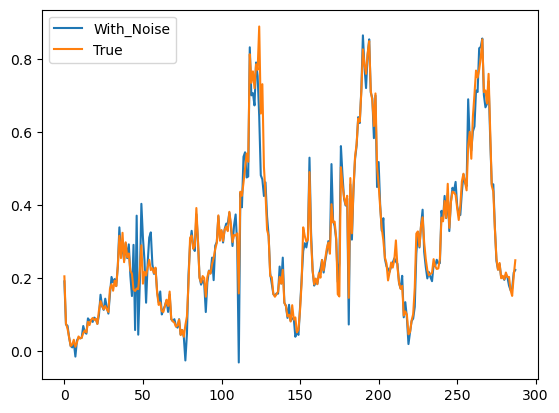

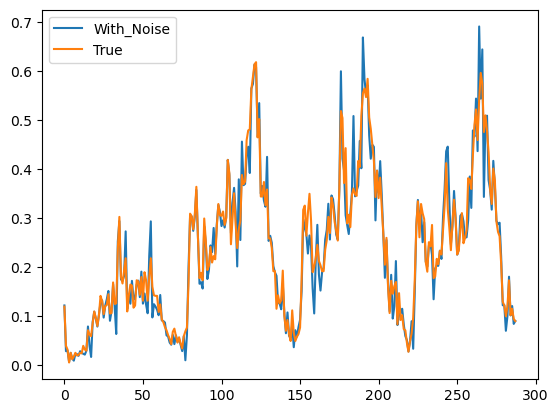

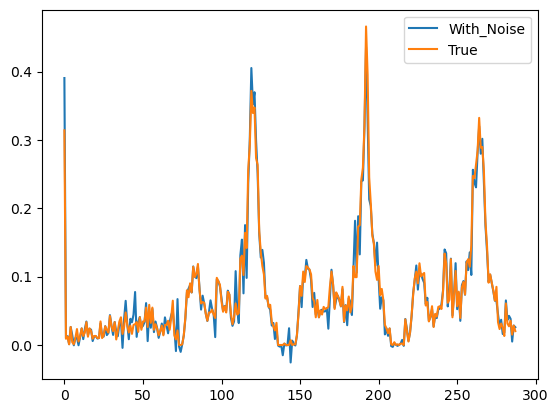

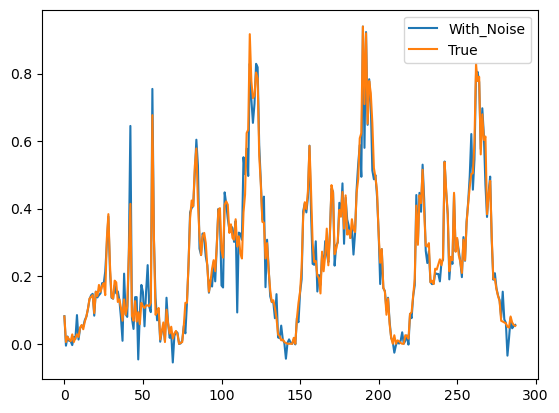

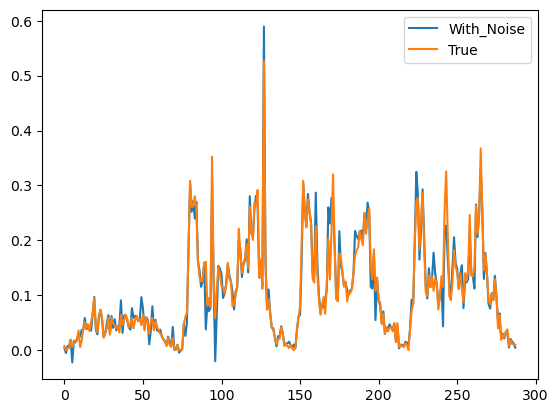

In [111]:
for station_ind in np.arange(ds.U_train.size(1)):
    pd.DataFrame({'With_Noise':U_train_copy[:,station_ind,-1], 
                  'True': ds.U_train[:,station_ind,-1]
                  }).iloc[:96*3].plot()

In [43]:
import pandas as pd
import numpy as np
import math 
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from constants.paths import USELESS_DATES
import matplotlib.pyplot as plt 

def get_noise_from_time_series(ds,min_count = 10, period = [24*7*4,24*4]):
    '''
    ds : PersonnalInput ou DataSet object 
    min_count : défini le minimum d'occurence d'un tuple (weekday,hour) pour qu'on y input avec la médiane.
                Sinon on input (weekday,hour) avec la mediane des valeurs aggrégée par (hour)
    period : liste de périodes associées aux différentes périodicités de la série temporelle. S
              Si on considère que y a D time-steps entre deux jours consécutif, et W entre deux semaines consécutives, alors period = [W,D] est adapté.
    '''
    df_verif_train = ds.tensor_limits_keeper.df_verif_train
    dates_used_in_train = pd.Series(pd.concat([df_verif_train[c] for c in df_verif_train.columns]).unique()).sort_values() # Concat forbidden indexes within each columns

    # Get corresponding indices:
    df_verif_train_ind = pd.DataFrame()
    for c in df_verif_train.columns:
        df_verif_train_ind[c] = df_verif_train.index + int(c.split('t')[-1])
    ind_used_in_train = pd.Series(pd.concat([df_verif_train_ind[c] for c in df_verif_train_ind.columns]).unique()).sort_values()

    # Reindex 
    reindex_dates = pd.date_range(dates_used_in_train.min(),dates_used_in_train.max(),freq=f"{1/ds.time_step_per_hour}h")


    forbidden_hour = USELESS_DATES['hour']
    forbidden_weekday = USELESS_DATES['weekday']
    reindex_dates = reindex_dates[~reindex_dates.hour.isin(forbidden_hour)&~reindex_dates.hour.isin(forbidden_weekday)]
    

    time_series_for_seasonal_decomposition = impute_median_by_dow_hour(ds.raw_values[ind_used_in_train].numpy(),dates_used_in_train,reindex_dates,ds.spatial_unit,min_count)

   
    decomposition = {}
    for col in time_series_for_seasonal_decomposition.columns:
        decomposition_i = ts_decomposition(time_series_for_seasonal_decomposition[col], period=period,take_abs= False)
        decomposition[col] = decomposition_i

    return decomposition

def ts_decomposition(ts: pd.Series, period: int = 7, take_abs: bool = False) -> pd.Series:
    """
    Décompose la série temporelle `ts` (index datetime) en (trend, season, resid).
    Retourne la composante de bruit (résidu) sous forme d'un pd.Series indexé
    par les mêmes datetimes."""
    if False:
        result = seasonal_decompose(ts, model='additive', period=period)
    if False : 
        stl = STL(ts, period=period)
        result = stl.fit()
    if True:
        mstl = MSTL(ts, periods=period)
        result = mstl.fit()
    output  = {
        'trend': result.trend.dropna(),
        'seasonal': result.seasonal.dropna(),
        'resid': result.resid.dropna()  # Souvent NaN au debut ou fin 
    }

    # Si on veut juste l'amplitude du Bruit: 
    if take_abs:
        output['resid'] = output['resid'].abs()
    
    return output

def add_calendar_columns(df,calendar_informations):
    if 'weekday' in calendar_informations:
        df['weekday'] = df.index.weekday
    if 'hour' in calendar_informations:
        df['hour'] = df.index.hour
    if 'minute' in calendar_informations:
        df['minute'] = df.index.minute
    if 'hour_minute' in calendar_informations:
        df['hour_minute'] = df.apply(lambda row: f"{row['hour']}:{row['minute']}",axis=1)
    return df
 



def impute_median_by_dow_hour(data: pd.DataFrame,dates_used_in_train,reindex_dates,columns,min_count: int = 10) -> pd.DataFrame:
    """
    Impute les valeurs manquantes de `data` en se basant sur :
      1) La médiane par (jour_de_semaine, heure) si le nombre de points dans ce groupe >= min_count
      2) Sinon, la médiane par heure (tous jours confondus) en fallback.

    Hypothèse : df.index est de type DatetimeIndex
    """
    # Get time_serie_for_seasonal_decomposition
    df_base_for_inputation = pd.DataFrame(data = data,index = dates_used_in_train,columns=columns)
    columns = df_base_for_inputation.columns
    df_base_for_inputation = add_calendar_columns(df_base_for_inputation,['weekday','hour','minute'])

    # median by (weekday,hour,minute) 
    group_dow_hour_minute = df_base_for_inputation.groupby(['hour', 'weekday','minute'])
    median_dow_hour_minute = group_dow_hour_minute.transform('median')
    count_dow_hour_minute = group_dow_hour_minute.transform('count')

    # median by (weekday,hour) 
    group_dow_hour = df_base_for_inputation.groupby(['hour', 'weekday'])
    median_dow_hour = group_dow_hour.transform('median').drop(columns=['minute'])
    count_dow_hour = group_dow_hour.transform('count').drop(columns=['minute'])

    # median by (hour) 
    group_hour = df_base_for_inputation.groupby('hour')
    median_hour = group_hour.transform('median').drop(columns=['weekday','minute'])

    # Median by (weekday,hour,minute). If not enough then median by (weekday,hour). If not enough then median by (hour) 
    #impute_val = np.where(count_dow_hour < min_count, median_hour, median_dow_hour)
    impute_val1 = np.where(count_dow_hour_minute > min_count, median_dow_hour_minute, median_dow_hour)
    impute_val = np.where(count_dow_hour > min_count, impute_val1, median_hour)

    values_to_be_imputed = pd.DataFrame(impute_val,index = df_base_for_inputation.index,columns = columns)
    values_to_be_imputed = add_calendar_columns(values_to_be_imputed,['weekday','hour','minute','hour_minute'])


    # Re-index df:
    time_series_for_seasonal_decomposition = df_base_for_inputation.reindex(reindex_dates) 
    time_series_for_seasonal_decomposition = add_calendar_columns(time_series_for_seasonal_decomposition,['weekday','hour','minute','hour_minute'])

    # Extract Sub-df of Nan Values: 
    data_to_input = time_series_for_seasonal_decomposition[time_series_for_seasonal_decomposition.isna().sum(axis=1) > 0]

    #L_input_col = [values_to_be_imputed.pivot_table(index = 'hour',columns = 'weekday', values = col) for col in columns]
    L_input_col = [values_to_be_imputed.pivot_table(index = 'hour_minute',columns = 'weekday', values = col) for col in columns]
    data_to_input = data_to_input.apply(lambda row: replace_values(row,L_input_col,columns),axis = 1)
    time_series_for_seasonal_decomposition =time_series_for_seasonal_decomposition.fillna(data_to_input).drop(columns = ['weekday','hour','minute','hour_minute'])
    return time_series_for_seasonal_decomposition



def replace_values_by_colunm(row,col,values_to_be_imputed):
    if math.isnan(row[col]):
        row[col] = values_to_be_imputed.at[int(row['hour']),int(row['weekday'])]
    return row 


def replace_values(row,L_input_col,columns):
    for k,col in enumerate(columns):
        #row[col] = L_input_col[col].at[int(row['hour']),int(row['weekday'])]
        row[col] = L_input_col[k].at[row['hour_minute'],int(row['weekday'])]
    return row 


def recompose_ts_and_plot(noise_from_decomposition,name,start = 96*7, nb_timeslots= 96*2):
    df = pd.DataFrame({'trend': noise_from_decomposition['trend'],
                                    'resid': noise_from_decomposition['resid']})

    if type(noise_from_decomposition['seasonal']) == pd.DataFrame:
        for col_i in noise_from_decomposition['seasonal'].columns:
            df[col_i] = noise_from_decomposition['seasonal'][col_i]
    else:
        df['seasonal'] = noise_from_decomposition['seasonal']

    df['TS'] = df.sum(axis=1)
    df.iloc[start:start+nb_timeslots].plot()
    plt.title(f"Seasonal decomposition of {name}")

## Get Noise from Train Time-Series

## Load Config from HP tuning
```trial_id = 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"
# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

In [ ]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

## Sans Week-ends

Trial id:  subway_in_STGCN_MSELoss_2025_01_06_08_00_94523

>>>> Load best CONFIG



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

92 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2913 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let

Loading BokehJS ...

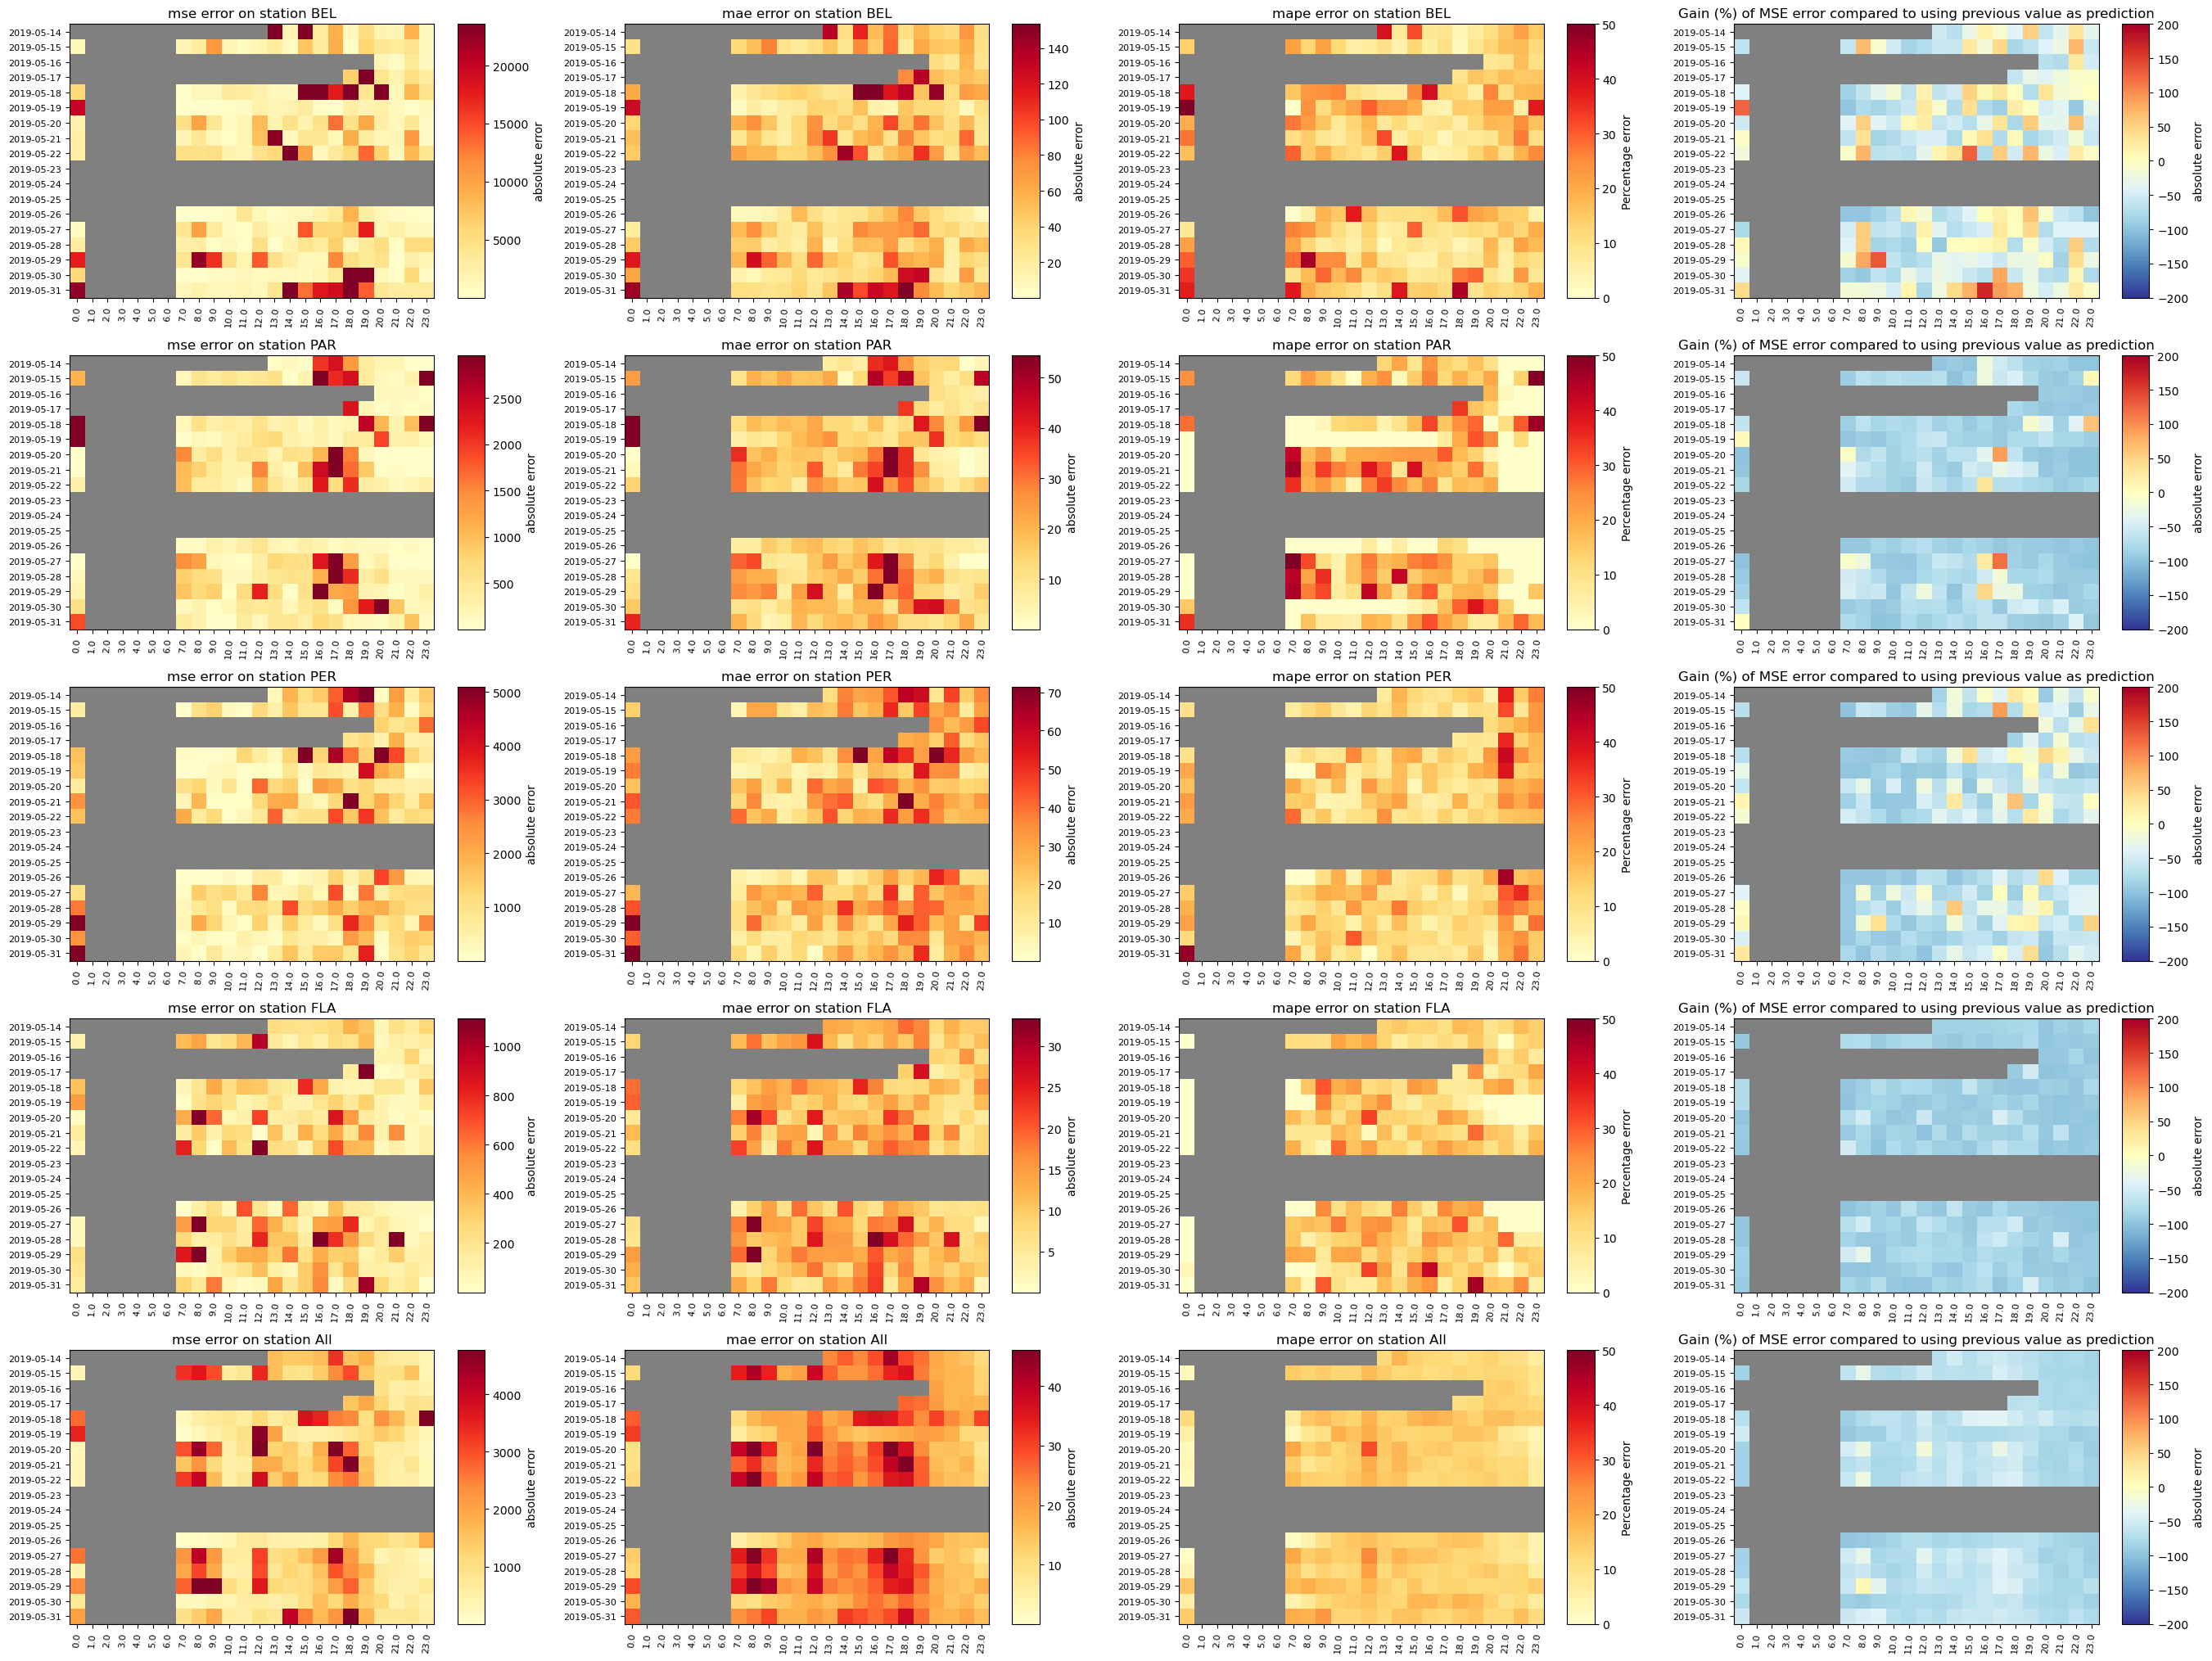

In [2]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':10,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True,  #False
                   'DA_method':'interpolation',
                   'DA_moment_to_focus' :[{'hours':[0,23],'weekdays':[1,3]}], # None
                   #'W' : args_best_model.Weeks,
                   #'D' : args_best_model.Days,
                   #'historical_length':args_best_model.H
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

## Avec Week-ends

In [ ]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','GER']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid','train']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        
        # Set figsize:
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)
    break


In [ ]:
ds.tensor_limits_keeper.df_verif_train.iloc[t+]

In [ ]:
for training_mode in ['train']:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(station)),
                                                limit_percentage_error = limit_percentage_error,
                                                stations = station)

In [56]:
from plotting.plotting import get_y_size_from_temporal_agg,temporal_aggregation_of_attn_weight
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

def plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = None,temporal_agg = None,save=None,stations= None):

    # Load Inputs : 
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)
    

    X = X.to(trainer.args.device)
    Y = Y.to(trainer.args.device)
    X_c = [x_c.to(trainer.args.device)for x_c in X_c]
    # Init:
    num_heads = trainer.args.args_vision.num_heads
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations)*num_heads 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)*num_heads 
    num_cols = 4
    

    nb_rows = (nb_stations_to_plot + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_stations_to_plot//num_cols))))


    for station_i in range(nb_stations_to_plot//num_heads):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = trainer.model.netmob_vision.model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        nb_contextuals = attn_weights.size(-1)

        mh_attn_weights_reshaped = attn_weights.squeeze().detach().cpu().numpy()  # Shape [B,num_heads,P]
        for head_i in range(num_heads):
            if num_heads == 1:
                attn_weights_reshaped = mh_attn_weights_reshaped
            else:
                attn_weights_reshaped = mh_attn_weights_reshaped[:,head_i,:]
            

            # Temporal Aggregation of attn weight:
            attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
            ax = plt.subplot(nb_rows, num_cols, (station_i*num_heads)+head_i + 1)  # Créer un subplot

            vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
            im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
            plt.colorbar(im,label='Attention Weight',shrink = 0.25)
            
            if temporal_agg is None:
                plt.title(f'Attention Weight\nof station {station_ind} ({spatial_units[station_ind]}) head {head_i} \nfor each sample of the batch')
                plt.ylabel('Samples')
            else:
                plt.title(f'Mean Attention Weight\nof station {station_i}({spatial_units[station_ind]}) head {head_i} \nby calendar class') 
                plt.ylabel('Calendar class')
            plt.xlabel('Contextual time-series')


            num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
            plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
            plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

        plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

def temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg):
    ''' 
    Return the temporal aggregation of attn weights to visualise them 

    args:
    ------
    temporal_agg : choices ['hour','weekday','weekday_hour','weekday_hour_minutes']
    '''

    if temporal_agg is not None:
        index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1]
        df = pd.DataFrame(attn_weights_reshaped,index = index_df) #,columns = ds.spatial_unit)
        weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


        if temporal_agg == 'hour':
            df_agg = df.groupby([df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{x:02d}"))

        elif temporal_agg == 'weekday':
            df_agg = df.groupby([df.index.weekday]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: weekdays[x]))

        elif temporal_agg == 'weekday_hour':
            df_agg = df.groupby([df.index.weekday,df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}"))

        elif temporal_agg == 'weekday_hour_minute':
            df_agg = df.groupby([df.index.weekday,df.index.hour,df.index.minute]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}:{x[2]:02d}"))
        else:
            raise NotImplementedError(f'Temporal aggregation {temporal_agg} has not been implemented')
        attn_weights_reshaped = df_agg.values  
    else:
        str_dates = list(df.index.strftime('%Y-%m-%d %H:%M'))

    return attn_weights_reshaped,str_dates


In [ ]:
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'

plot_attn_weight(trainer,nb_calendar_data,ds= ds,training_mode = training_mode,temporal_agg = temporal_agg,save=save,stations= ['CUS','PER','PAR'])

In [ ]:
trainer.model.netmob_vision.model[0].attention.W_v

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode,temporal_agg,save)

### Evaluate config :

In [ ]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True}
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])


    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

## Load config defined 'by hand' :

In [ ]:
dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['BEL','PAR','AMP','FLA']   # 'BON'  #'GER'
# ...

modification = {'epochs' : 1, #100
                'lr':4e-4}
training_mode_to_visualise = ['test']

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)